# NLP/Unsupervised Learning Project

This notebook contains the bulk of the workflow for my NLP/Unsupervised learning project at Metis. The dataset I will be working with is a set of ~ 3 million reviews from RateBeer.com.  I will start off by loading a pre-processed dataframe that has been collected from raw text and cleaned in all columns aside from the review_text column.

The goal for this notebook is to perform EDA, perform sentiment analysis, topic modeling, and eventually produce a content-based recommender for beers

In [20]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modeling
from sklearn.decomposition import NMF
from corextopic import corextopic as ct

# Recommendation by Distance
from sklearn.metrics import pairwise_distances

In [21]:
rb = pd.read_pickle('ratebeer_pickled_clean.pkl')

In [22]:
rb.head()

,beer_name,beer_id,beer_brewer_id,beer_abv,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_user,review_text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.6,0.6,0.65,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.8,0.7,0.65,2006-09-03,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5.0,Bohemian Pilsener,0.8,0.5,0.6,0.6,0.70,2000-05-19,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured..."


## Exploratory Data Analysis

I am using the full set here, but I may need a strategy to cut down the number of reviews with my limited computing resources.

In [23]:
rb.describe()

,beer_abv,review_appearance,review_aroma,review_palate,review_taste,review_overall
count,2.785526e+06,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06,2.924163e+06
mean,6.640799e+00,6.864054e-01,6.353608e-01,6.514471e-01,6.451929e-01,6.599848e-01
std,2.313753e+00,1.625114e-01,1.639165e-01,1.659462e-01,1.622888e-01,1.676290e-01
min,1.000000e-02,2.000000e-01,1.000000e-01,2.000000e-01,1.000000e-01,5.000000e-02
25%,5.000000e+00,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01
50%,6.000000e+00,6.000000e-01,7.000000e-01,6.000000e-01,7.000000e-01,7.000000e-01
75%,8.000000e+00,8.000000e-01,7.000000e-01,8.000000e-01,8.000000e-01,7.500000e-01
max,5.770000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


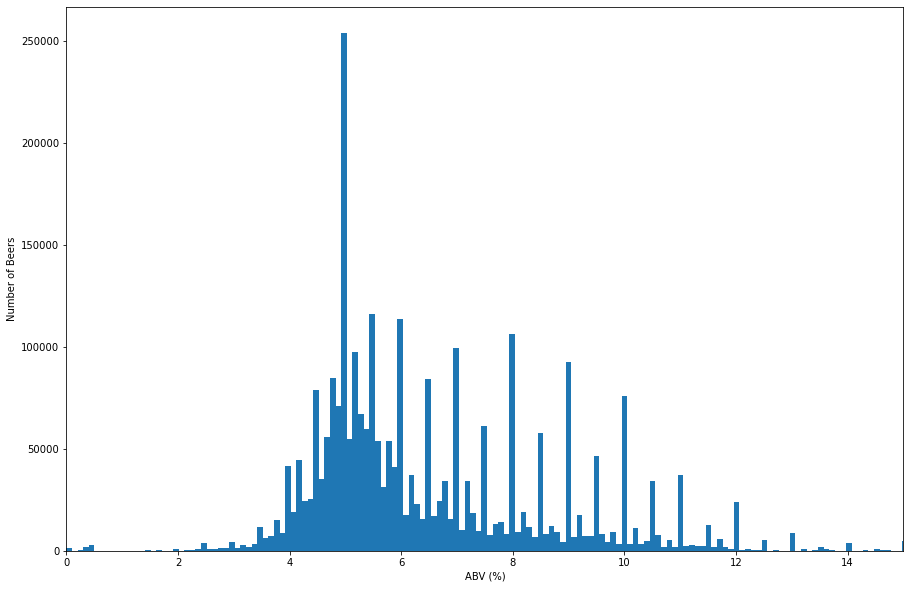

In [5]:
fig = plt.figure(figsize=(15,10))
bins = list(np.linspace(0, 20, 200))
plt.hist(rb['beer_abv'], bins=bins)
plt.xlim([0,15])
plt.xlabel('ABV (%)')
plt.ylabel('Number of Beers')
fig.show;

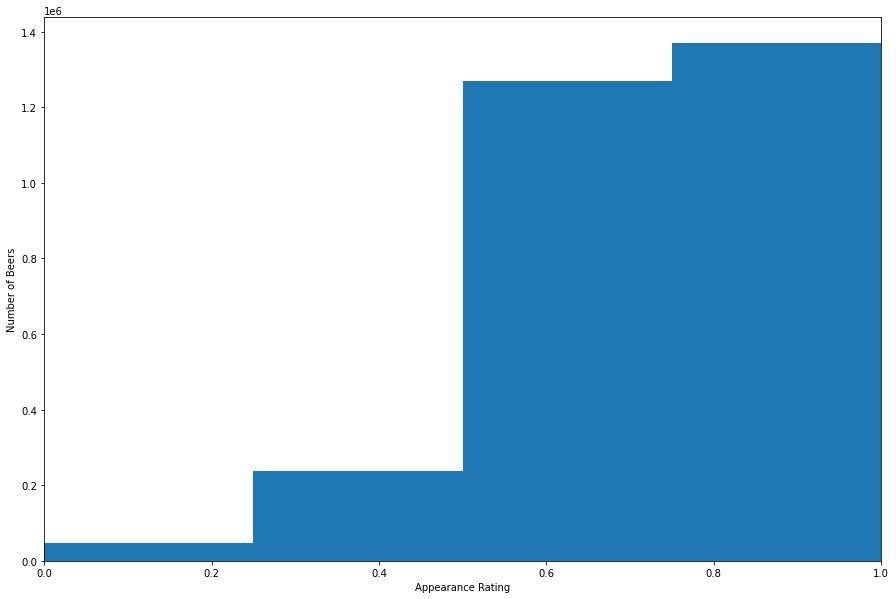

In [6]:
fig = plt.figure(figsize=(15,10))
bins = list(np.linspace(0, 1, 5))
plt.hist(rb['review_appearance'], bins=bins)
plt.xlim([0,1])
plt.xlabel('Appearance Rating')
plt.ylabel('Number of Beers')
fig.show;

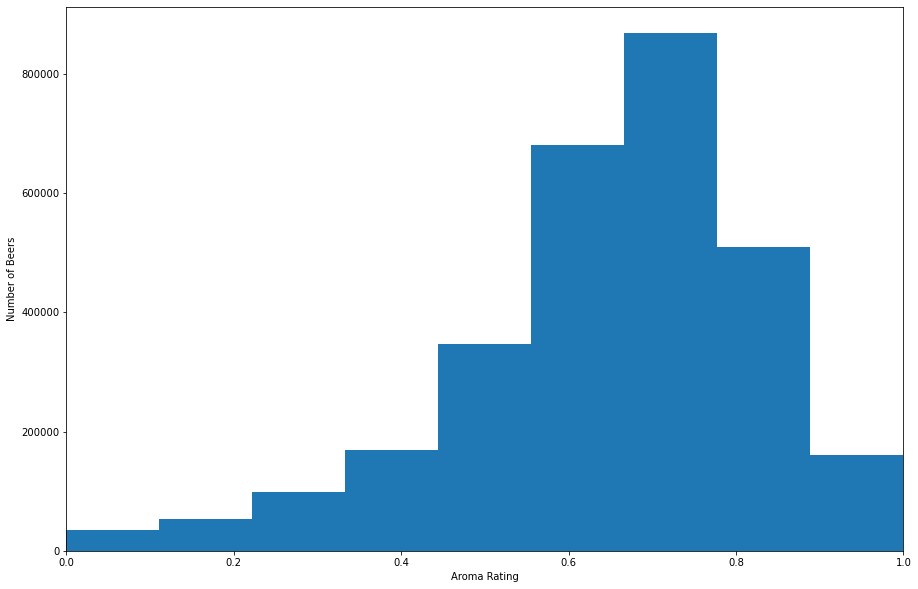

In [7]:
fig = plt.figure(figsize=(15,10))
bins = bins = list(np.linspace(0, 1, 10))
plt.hist(rb['review_aroma'], bins=bins)
plt.xlim([0,1])
plt.xlabel('Aroma Rating')
plt.ylabel('Number of Beers')
fig.show;

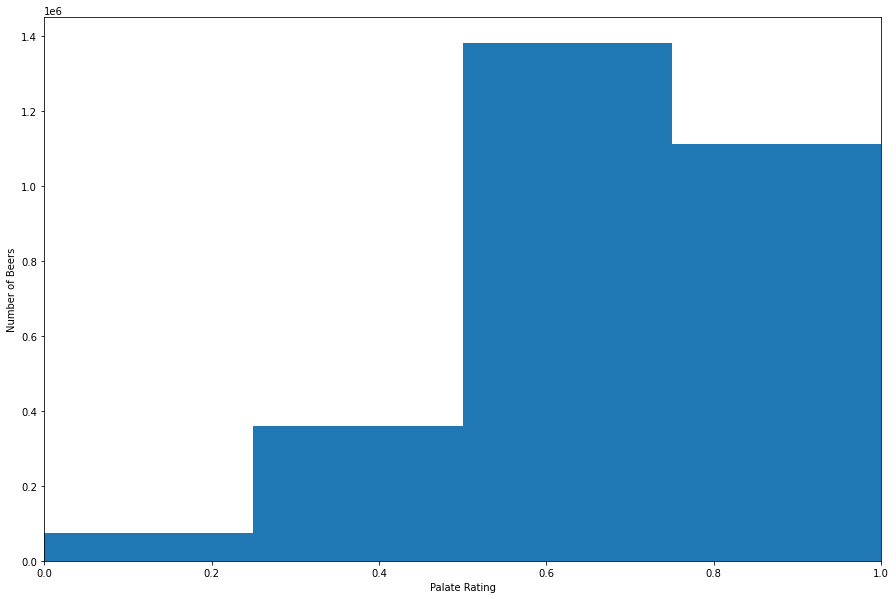

In [8]:
fig = plt.figure(figsize=(15,10))
bins = bins = list(np.linspace(0, 1, 5))
plt.hist(rb['review_palate'], bins=bins)
plt.xlim([0,1])
plt.xlabel('Palate Rating')
plt.ylabel('Number of Beers')
fig.show;

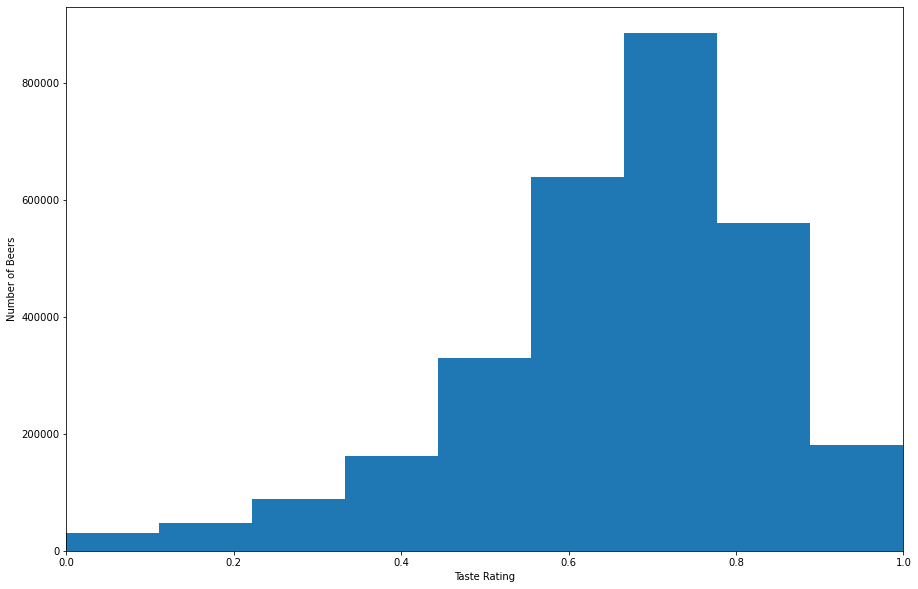

In [9]:
fig = plt.figure(figsize=(15,10))
bins = bins = list(np.linspace(0, 1, 10))
plt.hist(rb['review_taste'], bins=bins)
plt.xlim([0,1])
plt.xlabel('Taste Rating')
plt.ylabel('Number of Beers')
fig.show;

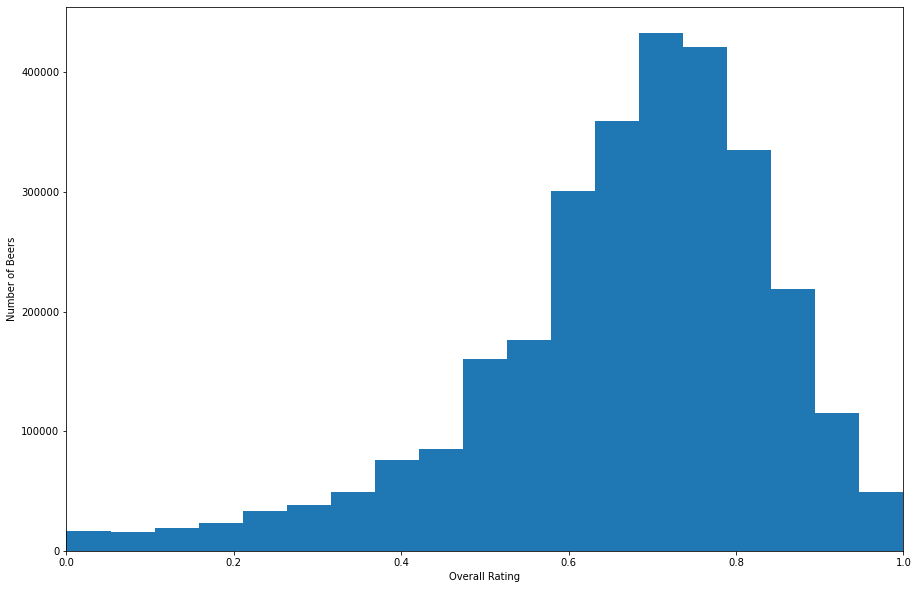

In [10]:
fig = plt.figure(figsize=(15,10))
bins = bins = list(np.linspace(0, 1, 20))
plt.hist(rb['review_overall'], bins=bins)
plt.xlim([0,1])
plt.xlabel('Overall Rating')
plt.ylabel('Number of Beers')
fig.show;

In [11]:
avg_review = rb.groupby('beer_id').mean().reset_index()
count_review = rb.groupby('beer_id').count().reset_index()

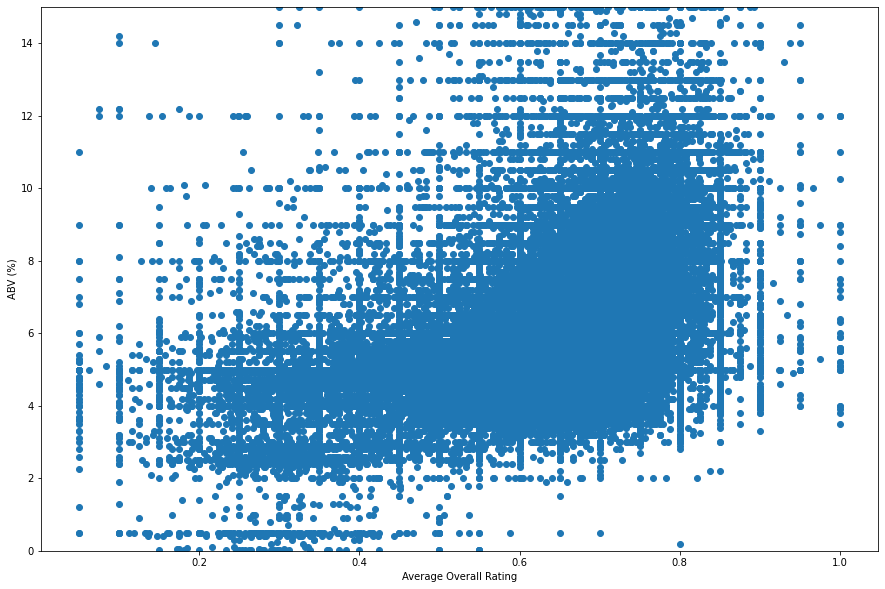

In [12]:
fig = plt.figure(figsize=(15,10))
x = avg_review['review_overall']
y = avg_review['beer_abv']
plt.scatter(x, y)
plt.ylabel('ABV (%)')
plt.xlabel('Average Overall Rating')
plt.ylim([0,15])
fig.show;

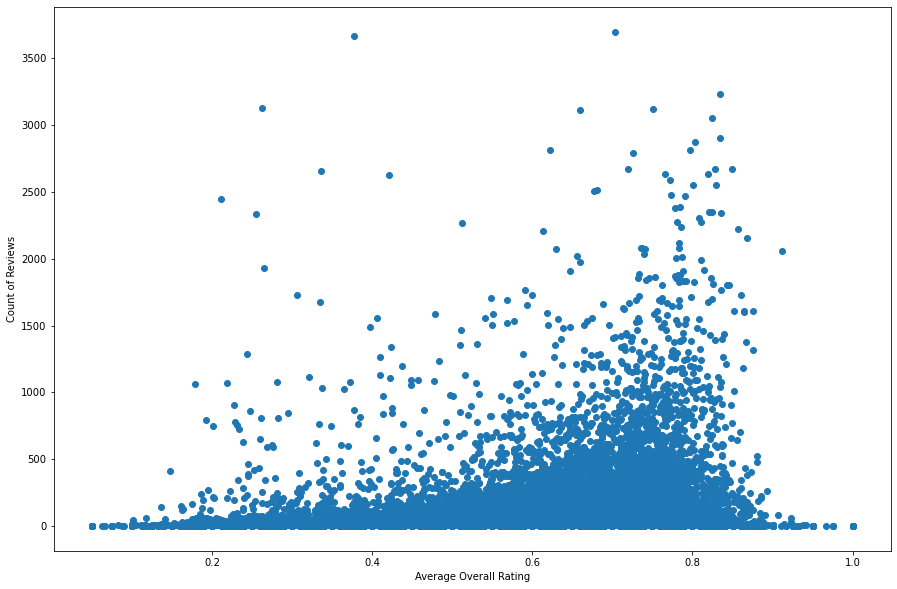

In [13]:
fig = plt.figure(figsize=(15,10))
x = avg_review['review_overall']
y = count_review['review_overall']
plt.scatter(x, y)
plt.ylabel('Count of Reviews')
plt.xlabel('Average Overall Rating')
fig.show;

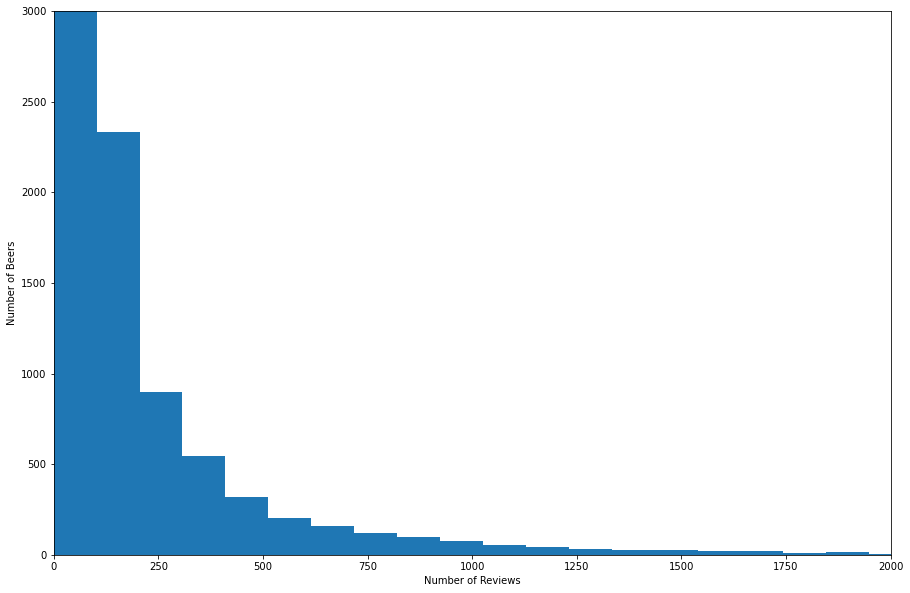

In [14]:
fig = plt.figure(figsize=(15,10))
bins = bins = list(np.linspace(0, 4000, 40))
plt.hist(count_review['review_overall'], bins=bins)
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Beers')
plt.xlim([0,2000])
plt.ylim([0,3000])
fig.show;

### Culling Data

I am going to filter down the dataset as I move into some of the NLP tasks. As we saw in the distribution of review counts, a large portion of the beers have less than 100 reviews on the site. The site allows the addition of beers by users, which could add potential duplication and some user's home brews to the set. For the purposes of our recommendations, we want the beers to be accessible to the user so we'll use more popular beers. 

This has the added benefit of saving processing time, as well. With luck it may be possible to circle back on a larger sample later

In [24]:
# Add a count column to the dataframe
rb['num_reviews'] = rb.groupby('beer_id')['review_overall'].transform('count')
# New dataframe, filtered by beers reviewed over 250 times
rb_filt = rb[rb['num_reviews'] > 250]

In [17]:
rb_filt.describe()

,beer_abv,review_appearance,review_aroma,review_palate,review_taste,review_overall,num_reviews
count,1.408051e+06,1.410235e+06,1.410235e+06,1.410235e+06,1.410235e+06,1.410235e+06,1.410235e+06
mean,7.058193e+00,7.112971e-01,6.580505e-01,6.771412e-01,6.703452e-01,6.897444e-01,9.561457e+02
std,2.375246e+00,1.686047e-01,1.719538e-01,1.715697e-01,1.669371e-01,1.715011e-01,6.816230e+02
min,5.000000e-02,2.000000e-01,1.000000e-01,2.000000e-01,1.000000e-01,5.000000e-02,2.510000e+02
25%,5.200000e+00,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,4.340000e+02
50%,6.500000e+00,8.000000e-01,7.000000e-01,6.000000e-01,7.000000e-01,7.000000e-01,7.510000e+02
75%,8.500000e+00,8.000000e-01,8.000000e-01,8.000000e-01,8.000000e-01,8.000000e-01,1.257000e+03
max,2.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.696000e+03


In [38]:
# Top 50 beers by popularity
rb_filt.groupby('beer_name').mean().sort_values('num_reviews', ascending=False).head(50)

,beer_abv,review_appearance,review_aroma,review_palate,review_taste,review_overall,num_reviews
beer_name,,,,,,,
Guinness Draught,4.1,0.890584,0.629924,0.701623,0.666477,0.703544,3696.0
Pabst Blue Ribbon,5.0,0.452758,0.306881,0.439869,0.381431,0.377444,3662.0
Dogfish Head 90 Minute Imperial IPA,9.0,0.807492,0.792663,0.810526,0.811207,0.834164,3230.0
Budweiser,5.0,0.400256,0.247185,0.358221,0.287300,0.261996,3126.0
Sierra Nevada Pale Ale (Bottle),5.6,0.730491,0.689324,0.722603,0.723309,0.750497,3119.0
Samuel Adams Boston Lager,4.8,0.697878,0.599807,0.650289,0.641833,0.660096,3110.0
Chimay Bleue (Blue) / Grande Réserve,9.0,0.824411,0.769830,0.803796,0.796073,0.824182,3056.0
North Coast Old Rasputin Russian Imperial Stout,9.0,0.870799,0.786329,0.817424,0.807679,0.834108,2904.0
Stone Arrogant Bastard Ale,7.2,0.825000,0.753656,0.774930,0.772946,0.802733,2872.0


## NLP Workflow

Using spaCy to process a sample of 50000 reviews

In [6]:
rb_filt_sample = rb_filt.sample(n=50000, random_state=23)

In [8]:
rb_filt_sample['doc'] = list(nlp.pipe(rb_filt_sample['review_text']))

In [100]:
rb_filt_sample.head()

,beer_name,beer_id,beer_brewer_id,beer_abv,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_user,review_text,num_reviews,doc,filtered_doc,lemm_doc
987512,Deschutes Jubel 2010,116030,233,11.0,American Strong Ale,0.6,0.7,0.6,0.8,0.80,2011-04-18,Cole,Pours black. Strong sweet malt aroma. Holds st...,295,"(Pours, black, ., Strong, sweet, malt, aroma, ...","[Pours, black, Strong, sweet, malt, aroma, Hol...","[pour, black, strong, sweet, malt, aroma, hold..."
2388484,New Belgium 1554 Enlightened Black Ale,1266,77,5.6,Traditional Ale,0.8,0.6,0.8,0.6,0.55,2009-07-07,jhumphries69,"22oz bomber. Pours deep, clear reddish dark br...",1383,"(22, oz, bomber, ., Pours, deep, ,, clear, red...","[22, bomber, Pours, deep, clear, reddish, dark...","[22, bomber, pour, deep, clear, reddish, dark,..."
1053109,Samuel Adams Boston Ale,159,32,5.1,Amber Ale,0.6,0.6,0.6,0.6,0.55,2004-01-01,kumite56,Off white head on an amber clear body. Malty ...,1483,"(Off, white, head, on, an, amber, clear, body,...","[Off, white, head, on, an, amber, clear, body,...","[off, white, head, on, an, amber, clear, body,..."
1996597,Dogfish Head Chicory Stout,1190,198,5.2,Stout,1.0,0.6,0.8,0.8,0.80,2005-07-22,michaeltrego,"Beautiful pour -- nice robust head, with a few...",1464,"(Beautiful, pour, --, nice, robust, head, ,, w...","[Beautiful, pour, --, nice, robust, head, with...","[beautiful, pour, --, nice, robust, head, with..."
2427324,Southern Tier Jah-va Imperial Coffee Stout,56276,3473,10.6,Imperial Stout,0.6,0.8,0.8,0.8,0.80,2008-07-30,alexanderj,Bottle; rating 1200. Dark brown in color with...,886,"(Bottle, ;, rating, 1200, ., , Dark, brown, i...","[Bottle, rating, 1200, Dark, brown, in, color,...","[bottle, rate, 1200, Dark, brown, in, color, w..."


In [9]:
# Save the tokenized sample
rb_filt_sample.to_pickle('spacy_tokenized.pkl')

### Data Cleaning with spaCy

Iterating through tokenization, lemmatization with different parameters, assessing results with some EDA

In [89]:
def token_filter(tokens):
    return [token for token in tokens if not (token.is_punct | 
                                              token.is_space | 
                                              token.is_digit | 
                                              token.like_num |
                                              token.is_stop | 
                                              token.is_bracket |
                                              len(token) < 3)]

In [90]:
def lemmatize(tokens):
    return [token.lemma_ for token in tokens]

In [91]:
rb_filt_sample['filtered_doc'] = rb_filt_sample['doc'].apply(token_filter)

In [96]:
rb_filt_sample['filtered_doc'].sample(5)

1721096    [beautiful, lacing, head, to, be, jealous, of,...
2069835    [Draft, Baja, Bean, Staunton, Orange, with, of...
527386     [On, tap, at, cerveceria, internacional, sevil...
1988521    [Nice, golden, color, Pleasant, hoppy, aroma, ...
75260      [Look, at, how, differently, the, top, raters,...
Name: filtered_doc, dtype: object

In [60]:
from collections import Counter

In [62]:
word_list = []

for doc in rb_filt_sample['filtered_doc']:
    for token in doc:
        word_list.append(token.text.lower())

top_words = Counter(word_list).most_common(50)
top_words

[('head', 34570),
 ('aroma', 29192),
 ('beer', 23103),
 ('flavor', 21098),
 ('sweet', 20519),
 ('bottle', 18161),
 ('light', 18071),
 ('nice', 17738),
 ('malt', 16549),
 ('taste', 15888),
 ('hops', 15467),
 ('finish', 15278),
 ('white', 14870),
 ('good', 14629),
 ('dark', 14517),
 ('pours', 13494),
 ('like', 12310),
 ('brown', 12264),
 ('caramel', 11529),
 ('medium', 10962),
 ('color', 10844),
 ('bitter', 10444),
 ('body', 10433),
 ('chocolate', 9930),
 ('bit', 9612),
 ('little', 8835),
 ('alcohol', 8535),
 ('amber', 8091),
 ('nt', 8076),
 ('notes', 8034),
 ('hop', 7871),
 ('citrus', 7755),
 ('orange', 7535),
 ('nose', 7339),
 ('carbonation', 7256),
 ('malty', 6941),
 ('dry', 6928),
 ('coffee', 6834),
 ('malts', 6706),
 ('bitterness', 6356),
 ('smooth', 6176),
 ('great', 6056),
 ('thin', 5841),
 ('fruit', 5765),
 ('roasted', 5669),
 ('slightly', 5628),
 ('clear', 5585),
 ('palate', 5522),
 ('creamy', 5488),
 ('black', 5460)]

In [68]:
len(word_list)

1606752

In [64]:
adj_list = []

for doc in rb_filt_sample['filtered_doc']:
    for token in doc:
        if token.pos_ == 'ADJ':
            adj_list.append(token.text.lower())

top_adj = Counter(adj_list).most_common(25)
top_adj

[('sweet', 19887),
 ('nice', 17234),
 ('white', 14700),
 ('good', 14272),
 ('dark', 13725),
 ('light', 13576),
 ('bitter', 10355),
 ('little', 8610),
 ('brown', 7939),
 ('dry', 5961),
 ('great', 5895),
 ('thin', 5787),
 ('smooth', 5736),
 ('roasted', 5465),
 ('hoppy', 5285),
 ('clear', 5146),
 ('golden', 5118),
 ('creamy', 4923),
 ('small', 4772),
 ('medium', 4714),
 ('thick', 4558),
 ('strong', 4459),
 ('tan', 4353),
 ('big', 4333),
 ('black', 4001)]

In [65]:
noun_list = []

for doc in rb_filt_sample['filtered_doc']:
    for token in doc:
        if token.pos_ == 'NOUN':
            noun_list.append(token.text.lower())

top_noun = Counter(noun_list).most_common(25)
top_noun

[('head', 33947),
 ('beer', 22486),
 ('aroma', 19283),
 ('bottle', 15607),
 ('malt', 15321),
 ('flavor', 14990),
 ('finish', 14239),
 ('hops', 13262),
 ('taste', 12609),
 ('caramel', 10960),
 ('color', 10639),
 ('body', 10396),
 ('chocolate', 9655),
 ('bit', 9580),
 ('alcohol', 7970),
 ('amber', 7801),
 ('notes', 7769),
 ('hop', 7531),
 ('carbonation', 7089),
 ('coffee', 6663),
 ('citrus', 6662),
 ('malts', 6638),
 ('bitterness', 6320),
 ('malty', 6068),
 ('nose', 5876)]

In [66]:
verb_list = []

for doc in rb_filt_sample['filtered_doc']:
    for token in doc:
        if token.pos_ == 'VERB':
            verb_list.append(token.text.lower())

top_verb = Counter(verb_list).most_common(25)
top_verb

[('pours', 8998),
 ('poured', 3971),
 ('updated', 3586),
 ('drink', 2806),
 ('like', 2186),
 ('hops', 2003),
 ('think', 1941),
 ('s', 1754),
 ('tastes', 1594),
 ('smells', 1521),
 ('bodied', 1461),
 ('lingering', 1409),
 ('taste', 1401),
 ('burnt', 1393),
 ('leaves', 1302),
 ('brew', 1300),
 ('got', 1286),
 ('feel', 1280),
 ('expected', 1279),
 ('lasting', 1254),
 ('try', 1218),
 ('going', 1152),
 ('comes', 1089),
 ('makes', 1068),
 ('starts', 1016)]

In [98]:
rb_filt_sample['lemm_doc'] = rb_filt_sample['filtered_doc'].apply(lemmatize)

In [99]:
rb_filt_sample['lemm_doc'].sample()

1147861    [bottle, orange, pour, with, good, clarity, an...
Name: lemm_doc, dtype: object

In [101]:
rb_filt_sample.head()

,beer_name,beer_id,beer_brewer_id,beer_abv,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_user,review_text,num_reviews,doc,filtered_doc,lemm_doc
987512,Deschutes Jubel 2010,116030,233,11.0,American Strong Ale,0.6,0.7,0.6,0.8,0.80,2011-04-18,Cole,Pours black. Strong sweet malt aroma. Holds st...,295,"(Pours, black, ., Strong, sweet, malt, aroma, ...","[Pours, black, Strong, sweet, malt, aroma, Hol...","[pour, black, strong, sweet, malt, aroma, hold..."
2388484,New Belgium 1554 Enlightened Black Ale,1266,77,5.6,Traditional Ale,0.8,0.6,0.8,0.6,0.55,2009-07-07,jhumphries69,"22oz bomber. Pours deep, clear reddish dark br...",1383,"(22, oz, bomber, ., Pours, deep, ,, clear, red...","[22, bomber, Pours, deep, clear, reddish, dark...","[22, bomber, pour, deep, clear, reddish, dark,..."
1053109,Samuel Adams Boston Ale,159,32,5.1,Amber Ale,0.6,0.6,0.6,0.6,0.55,2004-01-01,kumite56,Off white head on an amber clear body. Malty ...,1483,"(Off, white, head, on, an, amber, clear, body,...","[Off, white, head, on, an, amber, clear, body,...","[off, white, head, on, an, amber, clear, body,..."
1996597,Dogfish Head Chicory Stout,1190,198,5.2,Stout,1.0,0.6,0.8,0.8,0.80,2005-07-22,michaeltrego,"Beautiful pour -- nice robust head, with a few...",1464,"(Beautiful, pour, --, nice, robust, head, ,, w...","[Beautiful, pour, --, nice, robust, head, with...","[beautiful, pour, --, nice, robust, head, with..."
2427324,Southern Tier Jah-va Imperial Coffee Stout,56276,3473,10.6,Imperial Stout,0.6,0.8,0.8,0.8,0.80,2008-07-30,alexanderj,Bottle; rating 1200. Dark brown in color with...,886,"(Bottle, ;, rating, 1200, ., , Dark, brown, i...","[Bottle, rating, 1200, Dark, brown, in, color,...","[bottle, rate, 1200, Dark, brown, in, color, w..."


In [10]:
def token_filter_final(tokens):
    return [token.lemma_ for token in tokens if not (token.is_punct | 
                                              token.is_space | 
                                              token.is_digit | 
                                              token.like_num |
                                              token.is_stop | 
                                              token.is_bracket)]

In [11]:
rb_filt_sample['final_doc'] = rb_filt_sample['doc'].apply(token_filter_final)

In [12]:
rb_filt_sample['final_doc'] = rb_filt_sample['final_doc'].str.join(' ')

In [13]:
rb_filt_sample['final_doc'].sample(5)

1060942    update NOV middle road porter overall good tas...
2156411    taste honey bit sweet average beer nt taste ov...
1756555    bottle LCBO Pale golden quickly vanish medium ...
824560     day fiend raspberry beer lot change day thing ...
371455     pour dark black thin fading brown head Smells ...
Name: final_doc, dtype: object

In [14]:
rb_filt_sample.to_pickle('spacy_processed')

In [2]:
rb_filt_sample = pd.read_pickle('spacy_processed')

In [4]:
X = rb_filt_sample['final_doc']

vect = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.8, min_df=0.03)
X_vect = vect.fit_transform(X)
tfidf = pd.DataFrame(X_vect.toarray(), columns=vect.get_feature_names())

In [5]:
tfidf

,aftertaste,alcohol,ale,amber,amber color,appearance,apple,aroma,aroma sweet,average,...,warm,watery,way,wheat,white,white head,white head aroma,yeast,yeasty,yellow
0,0.000000,0.000000,0.266689,0.000000,0.0,0.0,0.000000,0.117565,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.113432,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.047574,0.0,0.0,...,0.123066,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.245903,0.0,0.0,0.000000,0.136905,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.193521,0.207994,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.136360,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.132221,0.000000,0.000000,0.0,0.0,0.000000,0.070183,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.203613,0.000000,0.000000,0.153387,0.0,0.0,0.000000,0.085397,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
49996,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.109687,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
49997,0.229605,0.362837,0.000000,0.172967,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.136121,0.146302,0.0,0.0,0.0,0.000000
49998,0.254654,0.201211,0.000000,0.000000,0.0,0.0,0.000000,0.106804,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.244505


In [6]:
vect.get_feature_names()

['aftertaste',
 'alcohol',
 'ale',
 'amber',
 'amber color',
 'appearance',
 'apple',
 'aroma',
 'aroma sweet',
 'average',
 'bad',
 'balance',
 'balanced',
 'banana',
 'beer',
 'beige',
 'beige head',
 'belgian',
 'big',
 'bit',
 'bitter',
 'bitter finish',
 'bitterness',
 'black',
 'bodied',
 'body',
 'bottle',
 'bottle pour',
 'bread',
 'brew',
 'brown',
 'brown head',
 'burn',
 'caramel',
 'caramel malt',
 'carbonation',
 'character',
 'cherry',
 'chocolate',
 'citrus',
 'clean',
 'clear',
 'cloudy',
 'coffee',
 'color',
 'colour',
 'come',
 'complex',
 'copper',
 'creamy',
 'crisp',
 'dark',
 'dark brown',
 'dark fruit',
 'decent',
 'deep',
 'drink',
 'drinkable',
 'dry',
 'earthy',
 'easy',
 'end',
 'enjoy',
 'expect',
 'fairly',
 'feel',
 'finish',
 'flavor',
 'flavour',
 'floral',
 'foamy',
 'fresh',
 'frothy',
 'fruit',
 'fruity',
 'glass',
 'gold',
 'golden',
 'good',
 'grain',
 'grapefruit',
 'great',
 'hazy',
 'head',
 'head aroma',
 'heavy',
 'high',
 'hint',
 'honey',
 'h

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
nmf = NMF(4)
doc_topic = nmf.fit_transform(X_vect)

/home/mattzirp/.conda/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [10]:
topic_word = pd.DataFrame(nmf.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = vect.get_feature_names())
topic_word

,aftertaste,alcohol,ale,amber,amber color,appearance,apple,aroma,aroma sweet,average,...,warm,watery,way,wheat,white,white head,white head aroma,yeast,yeasty,yellow
component_1,0.222,0.646,0.026,0.686,0.165,0.145,0.470,1.573,0.345,0.317,...,0.164,0.356,0.046,0.597,2.228,2.050,0.896,0.942,0.461,0.887
component_2,0.198,0.255,0.380,0.000,0.000,0.159,0.042,0.192,0.000,0.109,...,0.146,0.133,0.332,0.154,0.000,0.000,0.000,0.000,0.011,0.079
component_3,0.167,0.658,0.042,0.000,0.000,0.094,0.000,0.839,0.114,0.049,...,0.206,0.056,0.075,0.000,0.000,0.000,0.000,0.003,0.000,0.000
component_4,0.168,0.068,0.504,0.861,0.382,0.116,0.000,0.681,0.000,0.030,...,0.065,0.000,0.147,0.000,0.087,0.066,0.000,0.000,0.000,0.000


In [11]:
display_topics(nmf, vect.get_feature_names(), 15)


Topic  0
light, white, white head, sweet, head, aroma, medium, bottle, body, pour, finish, flavor, orange, golden, note

Topic  1
beer, like, good, nt, taste, drink, great, bad, smell, try, think, taste like, look, little, update

Topic  2
chocolate, dark, coffee, brown, roasted, black, malt, tan, roasted malt, tan head, dark brown, head, flavor, pour, aroma

Topic  3
hop, nice, malt, ipa, citrus, bitter, good, pine, hoppy, amber, flavor, caramel, balance, bitterness, grapefruit


In [80]:
count_vect = CountVectorizer(stop_words='english',ngram_range=(1,3), max_df=0.90, min_df=0.05, binary=True)
doc_word = count_vect.fit_transform(X)
words = list(np.asarray(count_vect.get_feature_names()))

In [85]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
# topic_model.fit(doc_word, words=words, docs=X)
anchors = [['chocolate','coffee','black','dark','brown'], 
          ['white','citrus','orange','hazy','cloudy'],
          ['head', 'pour', 'aroma', 'lacing', 'bottle'],
          ['body', 'finish', 'carbonation', 'mouthfeel'],
          ['malt', 'fruit', 'sweet', 'bitter', 'note']]
topic_model.fit(doc_word, words=words, docs=X, anchors=anchors, anchor_strength=1)

In [86]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: chocolate,tan,coffee,dark,tan head,brown,black,dark brown,roasted,golden
1: white head,white,white head aroma,citrus,hazy,orange,cloudy,like,nt,great
2: head,pour,aroma,head aroma,bottle,bottle pour,lacing,oz bottle,oz,flavor
3: medium,body,medium body,carbonation,finish,light,dry,bodied,mouthfeel,creamy
4: hop,malt,caramel,sweet,amber,bitterness,note,pine,balance,alcohol


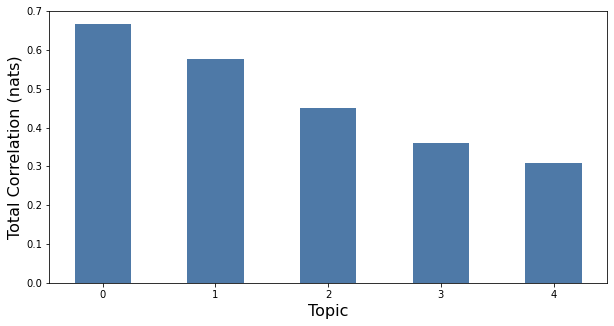

In [87]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [93]:
topic_features = pd.DataFrame(topic_model.p_y_given_x)
topic_features

,0,1,2,3,4
0,0.199987,0.000001,0.065788,0.001338,0.273153
1,0.999999,0.000001,0.998916,0.994513,0.999960
2,0.004533,0.999999,0.681502,0.025519,0.987435
3,0.821233,0.000001,0.951932,0.003992,0.148947
4,0.999999,0.000001,0.999999,0.161890,0.999933
...,...,...,...,...,...
49995,0.004523,0.000001,0.670864,0.999670,0.962114
49996,0.059735,0.000001,0.999999,0.255694,0.954515
49997,0.072601,0.999999,0.040228,0.004733,0.421582
49998,0.000143,0.000001,0.642404,0.016887,0.645618


In [112]:
rb_filt_sample = rb_filt_sample.reset_index()

In [113]:
features = rb_filt_sample.join(topic_features)

In [114]:
features

,level_0,index,beer_name,beer_id,beer_brewer_id,beer_abv,beer_style,review_appearance,review_aroma,review_palate,...,review_user,review_text,num_reviews,doc,final_doc,0,1,2,3,4
0,0,987512,Deschutes Jubel 2010,116030,233,11.0,American Strong Ale,0.6,0.7,0.6,...,Cole,Pours black. Strong sweet malt aroma. Holds st...,295,"(Pours, black, ., Strong, sweet, malt, aroma, ...",pour black strong sweet malt aroma hold strong...,0.199987,0.000001,0.065788,0.001338,0.273153
1,1,2388484,New Belgium 1554 Enlightened Black Ale,1266,77,5.6,Traditional Ale,0.8,0.6,0.8,...,jhumphries69,"22oz bomber. Pours deep, clear reddish dark br...",1383,"(22, oz, bomber, ., Pours, deep, ,, clear, red...",oz bomber pour deep clear reddish dark brown t...,0.999999,0.000001,0.998916,0.994513,0.999960
2,2,1053109,Samuel Adams Boston Ale,159,32,5.1,Amber Ale,0.6,0.6,0.6,...,kumite56,Off white head on an amber clear body. Malty ...,1483,"(Off, white, head, on, an, amber, clear, body,...",white head amber clear body Malty aroma hint b...,0.004533,0.999999,0.681502,0.025519,0.987435
3,3,1996597,Dogfish Head Chicory Stout,1190,198,5.2,Stout,1.0,0.6,0.8,...,michaeltrego,"Beautiful pour -- nice robust head, with a few...",1464,"(Beautiful, pour, --, nice, robust, head, ,, w...",beautiful pour nice robust head droplet race d...,0.821233,0.000001,0.951932,0.003992,0.148947
4,4,2427324,Southern Tier Jah-va Imperial Coffee Stout,56276,3473,10.6,Imperial Stout,0.6,0.8,0.8,...,alexanderj,Bottle; rating 1200. Dark brown in color with...,886,"(Bottle, ;, rating, 1200, ., , Dark, brown, i...",bottle rate Dark brown color small medium shor...,0.999999,0.000001,0.999999,0.161890,0.999933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,2540960,Goose Island Honkers Ale,811,12853,4.3,Bitter,1.0,0.6,0.8,...,larsga,Medium offwhite head. Beautiful amber body wit...,1214,"(Medium, offwhite, head, ., Beautiful, amber, ...",medium offwhite head beautiful amber body carb...,0.004523,0.000001,0.670864,0.999670,0.962114
49996,49996,7864,Chimay Bleue (Blue) / Grande Réserve,53,12,9.0,Belgian Strong Ale,0.8,0.8,1.0,...,Matts_Property,"UPDATED: MAY 16, 2011 330ml bottle from Stirch...",3056,"(UPDATED, :, MAY, 16, ,, 2011, 330ml, bottle, ...",update 330ml bottle Stirchley Wines Spirits po...,0.059735,0.000001,0.999999,0.255694,0.954515
49997,49997,1013649,North Coast Old Stock Ale,7178,108,11.7,Barley Wine,0.8,0.7,0.8,...,DrunkenWeasel,"UPDATED: DEC 15, 2005 A beer that runs up on y...",1548,"(UPDATED, :, DEC, 15, ,, 2005, A, beer, that, ...",update DEC beer run kick face beer strong inte...,0.072601,0.999999,0.040228,0.004733,0.421582
49998,49998,837135,New Glarus Spotted Cow,7453,1248,5.1,Cream Ale,0.6,0.3,0.6,...,NYHarvey,Courtesy of Bockyhorsey.\t<P>\tMild grain and ...,741,"(Courtesy, of, Bockyhorsey, ., \t, <, P, >, \t...",Courtesy Bockyhorsey p Mild grain light alcoho...,0.000143,0.000001,0.642404,0.016887,0.645618


In [117]:
topics_dict = {0: 'dark_styles',
               1: 'light_styles',
               2: 'presentation',
               3: 'mouthfeel', 
               4: 'tasting_notes'}

In [115]:
features = features.drop(labels=['index', 'beer_id', 'beer_brewer_id','review_time', 'review_user', 'review_text', 'num_reviews', 'doc', 'final_doc'], axis=1)

In [134]:
features = features.rename(columns=topics_dict)
features = features.drop('beer_abv', axis=1)

In [135]:
features = features.groupby(['beer_name']).mean()
features

,review_appearance,review_aroma,review_palate,review_taste,review_overall,dark_styles,light_styles,presentation,mouthfeel,tasting_notes
beer_name,,,,,,,,,,
13th Century Grut Bier,0.700000,0.750000,0.633333,0.733333,0.750000,0.003212,0.333334,0.562432,0.403648,0.232347
1809 Berliner Style Weisse,0.704348,0.693478,0.743478,0.739130,0.755435,0.002506,0.550126,0.714923,0.169812,0.174891
21st Amendment Back in Black,0.773333,0.696667,0.680000,0.706667,0.713333,0.665482,0.066668,0.591333,0.157745,0.632007
21st Amendment Bitter American,0.666667,0.733333,0.716667,0.708333,0.733333,0.002758,0.615798,0.777697,0.256147,0.712635
21st Amendment Brew Free or Die IPA,0.708108,0.702703,0.718919,0.691892,0.720270,0.003911,0.561900,0.630602,0.329231,0.773115
...,...,...,...,...,...,...,...,...,...,...
Yuengling Light Lager,0.488889,0.422222,0.488889,0.422222,0.433333,0.005288,0.000001,0.121546,0.026030,0.020540
Yuengling Lord Chesterfield Ale,0.542857,0.457143,0.533333,0.500000,0.511905,0.001258,0.057891,0.364239,0.113685,0.244434
Yuengling Original Black and Tan,0.718519,0.559259,0.607407,0.603704,0.635185,0.513422,0.074075,0.235385,0.159058,0.199797


In [175]:
def get_recommendation(features, beer):
    target_row = features.loc[beer].values.reshape(1,-1)
    dist = pairwise_distances(target_row, features)
    top_five = dist.argsort()[0][1:6]
    suggestions = features.iloc[top_five,0:0]
    return suggestions

In [185]:
beer = 'Blue Point Toasted Lager'
get_recommendation(features=features, beer=beer)

""
beer_name
Widmer Brothers Drop Top Amber Ale
Brooklyn Pilsner
Leinenkugels Red
Redhook ESB
Rodenbach Redbach


In [184]:
beer_names = features.reset_index()
beer_names['beer_name'].to_csv('sampled_beers.csv')